## Generate positive amazon reviews with a character level LSTM

In [1]:
import math
import re
import random
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from datautils.vocabulary import Vocabulary

from tqdm import tqdm_notebook

import six

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

## Dataset: Amazon Reviews

1. Description of dataset
2. What is the format
3. Why are we using it
4. Where did you get it. 


## Constants

In [55]:
## CONSTANTS

class constants:
    AMAZON_REVIEW_CSV = '/research/data/amazon_reviews/train_small.csv'
    CHAR_SEQUENCE_LENGTH = 30
    CHAR_START_TOKEN = "^"
    CHAR_END_TOKEN= "_"

## Data

In [56]:
class AmazonReviewsDataset(object):
    """Amazon Reviews text dataset for language modeling.
    
       Args:
        data_path (str): Path to Amazon reviews data file.
        num_samples (int): Number of amazon reviews to load.
        max_review_length (int): Filters reviews longer than specified length.
            [default=400]
        max_sequence_length (int): Max length of sequences for use in training language model.
            [default=40]
        sentiment (int): sentiment of reviews to select, 1 (negative) or 2 (positive).
            [default=2]
    """

    def __init__(self, data_path):
        data = pd.read_csv(data_path, names=['sentiment', 'title', 'review'])
        self.data = self.preprocess(data)
        
    def preprocess(self, data):
        remove_special = lambda text: re.sub(r'[^A-Za-z0-9.!?#$\n]+', ' ', text)        
        data['review'] = data.review.apply(remove_special)
        return data
        
    def get_data(self, char_seq_length, sentiment="negative", only_n_samples=-1):
        """
        return the data for a specific sentiment, default is negative
        """
        
        sentiment = {"negative": 1, "positive": 2}[sentiment]
        data = self.data[self.data.sentiment==sentiment]
        text_list = data.review
        
        if only_n_samples > 0:
            indices = np.random.choice(np.arange(len(text_list)), size=only_n_samples, replace=False)
            text_list = [text_list.iloc[i] for i in indices]
        
        return self.generate_windowed_sequences(text_list, char_seq_length)
    
    def get_character_set(self):
        return set([char for review in self.data.review for char in review])
        
    def generate_windowed_sequences(self, text_list, char_seq_length=40, step_size=1):
        """
        .. note:: step_size is the inter-window step size
        """
        sequences = []
        next_chars = []
            
        for text in text_list:
            last_begin_index = len(text) - char_seq_length
            for begin_index in range(0, last_begin_index, step_size):
                end_index = begin_index + char_seq_length
                sequences.append(text[begin_index:end_index])
                next_chars.append(text[end_index])
        return sequences, next_chars
    

class AmazonReviewsVectorizer(object):
    def __init__(self, chars_vocab):
        self.chars_vocab = chars_vocab
        
    def save(self, filename):
        vec_dict = {"chars_vocab": self.chars_vocab.get_serializable_contents()}

        with open(filename, "w") as fp:
            json.dump(vec_dict, fp)
        
    @classmethod
    def load(cls, filename):
        with open(filename, "r") as fp:
            vec_dict = json.load(fp)

        vec_dict["chars_vocab"] = Vocabulary.deserialize_from_contents(vec_dict["chars_vocab"])
        return cls(**vec_dict)

    @classmethod
    def induce_from_text(cls, *texts):
        """
        """
        vocab = Vocabulary(use_unks=True,
                           use_start_end=True,
                           start_token=constants.CHAR_START_TOKEN,
                           end_token=constants.CHAR_END_TOKEN)
        for text in texts:
            for character_sequence in text:
                vocab.add_many(set(character_sequence))
        return cls(vocab)

    def convert_dataset(self, char_sequences, char_targets,  progbar_wrapper=None):

        num_data = len(char_sequences)
        
        seq_length = constants.CHAR_SEQUENCE_LENGTH + 2 # 2 for start, end tokens
        x_sequences = np.zeros((num_data, seq_length), dtype=np.int64)
        y_targets = np.zeros((num_data), dtype=np.int64)

        if progbar_wrapper is not None:
            enum = enumerate(progbar_wrapper(char_sequences))
        else:
            enum = enumerate(char_sequences)
            
        for seq_index, char_sequence in enum:
            x_sequences[seq_index] = list(self.chars_vocab.map(char_sequence, 
                                                         include_start_end=True))
            y_targets[seq_index] = self.chars_vocab[char_targets[seq_index]]

        return VectorizedSingleIODataset(x_sequences, y_targets)

class VectorizedSingleIODataset(Dataset):
    def __init__(self, x_input, y_target):
        self.x_input = x_input
        self.y_target = y_target

    def __len__(self):
        return len(self.x_input)

    def __getitem__(self, index):
        return {'x_input': self.x_input[index],
                'y_target': self.y_target[index],
                'x_lengths': len(self.x_input[index].nonzero()[0])}
    
class DataServer(object):
    def __init__(self, vectorized_data):
        self.vectorized_data = vectorized_data
        self.gpu_mode = False
        self.volatile_mode = False
    
    def serve_batches(self, batch_size, num_batches=-1, num_workers=0):
        datagen = DataLoader(self.vectorized_data, batch_size=batch_size, 
                             shuffle=True, num_workers=num_workers)
        for batch_index, batch in enumerate(datagen):
            out = {}
            for key, val in batch.items():
                if not isinstance(val, Variable):
                    val = Variable(val)
                if self.gpu_mode:
                    val = val.cuda()
                if self.volatile_mode:
                    val = val.volatile() 
                out[key] = val
                
            yield out
            if num_batches > 0 and batch_index > num_batches:
                break
                
    def enable_gpu_mode(self):
        self.gpu_mode = True
        
    def disable_gpu_mode(self):
        self.gpu_mode = False

## Build Model

In [59]:
class CharNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_rnn_layers=1):
        super(CharNN, self).__init__()
        
        self.emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers=num_rnn_layers)
        self.affine = nn.Linear(hidden_dim, vocab_size)
        
        
        self._cached_config = dict(embedding_dim=embedding_dim, 
                                   hidden_dim=hidden_dim,
                                   vocab_size=vocab_size,
                                   num_rnn_layers=num_rnn_layers)
        
    def hidden_from_x(self, x, zero_out=True):
        hidden = x.data.new(self.rnn.num_layers, 
                                     x.size(0), 
                                     self.rnn.hidden_size)
        if zero_out:
            hidden = hidden.zero_()
        else:
            stdv = 1. / math.sqrt(self.hidden.size(2))
            hidden.data.uniform_(-stdv, stdv)
        
        return Variable(hidden)
    
    def forward(self, x_in, apply_softmax=False, hidden=None, return_with_hidden=False):
        
        
        x_embedded = self.emb(x_in)
        if hidden is None:
            hidden = self.hidden_from_x(x_embedded, True)
        x_post_rnn, hidden = self.rnn(x_embedded, hidden)
        # get final vector in sequence
        x_post_rnn = x_post_rnn[:, -1, :] 
        out = self.affine(x_post_rnn)
        if apply_softmax:
            out = F.softmax(out)
        if return_with_hidden:
            return out, hidden
        else:
            return out
    
    def save(self, json_filename, model_state_filename):
        torch.save(self.state_dict(), model_state_filename)
        with open(json_filename, "w") as fp:
            json.dump(self._cached_config, fp)
    
    @classmethod
    def load(cls, json_filename, model_state_filename):
        with open(json_filename, "r") as fp:
            config = json.load(fp)
        out = cls(**config)
        out.load_state_dict(torch.load(model_state_filename))
        return out

In [67]:
class CrossEntTrainer(object):
    def __init__(self, model, optimizer_class, gpu_mode=False, learning_rate=0.0001):
        self.model = model
        if isinstance(optimizer_class, six.string_types):
            if not hasattr(torch.optim, optimizer_class):
                raise Exception("{} is not a valid optimizer".format(optimizer_class))
            optimizer_class = getattr(torch.optim, optimizer_class)
        self.optimizer = optimizer_class(model.parameters(), lr=learning_rate)
        self.loss = nn.CrossEntropyLoss()
        self.gpu_mode = gpu_mode
        self.loss_history = []
    
    def _reset_gradient(self):
        self.optimizer.zero_grad()
        self.model.zero_grad()
        
    def train(self, data_server, batch_size=64, num_batches=-1, num_epochs=1):
        if self.gpu_mode:
            self.model.cuda()
            data_server.enable_gpu_mode()
            print("enabling gpu mode")
        else:
            self.model.cpu()
            data_server.disable_gpu_mode()
        epoch_bar = tqdm_notebook(total=num_epochs, unit=" epochs", position=0)
        batch_bar = tqdm_notebook(unit=" batches", position=1)
        for _ in range(num_epochs):
            for batch in data_server.serve_batches(batch_size, num_batches):
                self._reset_gradient()
                yhat = self.model(batch['x_input'])
                computed_loss = self.loss(yhat, batch['y_target'])
                computed_loss.backward()
                self.optimizer.step()

                computed_loss_ = float(computed_loss.data.cpu().numpy()[0])
                batch_bar.set_postfix(loss=computed_loss_)
                self.loss_history.append(computed_loss_)
                batch_bar.update(1)
                
            sampled_text = sample_from(model, vectorizer, use_cuda=self.gpu_mode, n_length=50, burn=10)
            epoch_bar.set_postfix(sample=sampled_text)
            epoch_bar.update(1)

        batch_bar.clear()

In [62]:
def variable_from_string(vectorizer, a_string):
    out = np.array(list(vectorizer.chars_vocab.map(a_string)))
    return Variable(torch.LongTensor(out)).view(1,-1)

def sample_from(model, vectorizer, temperature=1.0, seed_text=None, use_cuda=True, hx=None, n_length=10, burn=0):
    if seed_text is None:
        seed_text = random.choice([vectorizer.chars_vocab.start_token])
    in_var = variable_from_string(vectorizer, seed_text)
    if use_cuda:
        in_var = in_var.cuda()
    for _ in range(n_length):
        if in_var.data.min() < 0:
            continue
        y_pred, hx = model(in_var, apply_softmax=False, hidden=hx, return_with_hidden=True)
        y_pred = torch.nn.functional.softmax(y_pred/temperature)
        in_var = torch.multinomial(y_pred)
        seed_text += vectorizer.chars_vocab.lookup(in_var.data.cpu().numpy().ravel()[0])
        if seed_text[-1] == constants.CHAR_END_TOKEN:
            break
    return seed_text[burn:]
    

In [ ]:
text_dataset = AmazonReviewsDataset(constants.AMAZON_REVIEW_CSV)
char_sequences, char_targets = text_dataset.get_data(constants.CHAR_SEQUENCE_LENGTH, only_n_samples=100)
char_set = text_dataset.get_character_set()
print(len(char_sequences), len(char_targets))

In [63]:
import os

if os.path.exists("model.json"):
    model = CharNN.load("model.json", "model.state")
    vectorizer = AmazonReviewsVectorizer.load("vectorizer.json")
    vectorizer.chars_vocab.freeze()
else:
    vectorizer = AmazonReviewsVectorizer.induce_from_text(char_set)
    vectorized_dataset = vectorizer.convert_dataset(char_sequences, char_targets, progbar_wrapper=tqdm_notebook)

    model_parameters = dict(embedding_dim=16, 
                            hidden_dim=32,
                            num_rnn_layers=1)
    model = CharNN(vocab_size=len(vectorizer.chars_vocab), **model_parameters)
    vectorizer.chars_vocab.freeze()

data_server = DataServer(vectorized_dataset)

In [68]:
trainer = CrossEntTrainer(model, "SGD", True, 0.005)

In [71]:
try:
    trainer.train(data_server, num_epochs=1000)
except KeyboardInterrupt:
    passp

enabling gpu mode


In [10]:

model.save("model.json", "model.state")
vectorizer.save("vectorizer.json")

In [53]:
model.cuda();

In [30]:
sample_from(model, vectorizer, temperature=0.1, n_length=100)

'^....................................................................................................'

In [33]:
sample_from(model, vectorizer, seed_text="^The computer", temperature=0.4, n_length=100)

'^The computerddistty threyt...d.d spitttyis thrittty thrittty threokistty thrittty...d.d threatttyis gmistty thre'

In [52]:
plt.scatter?

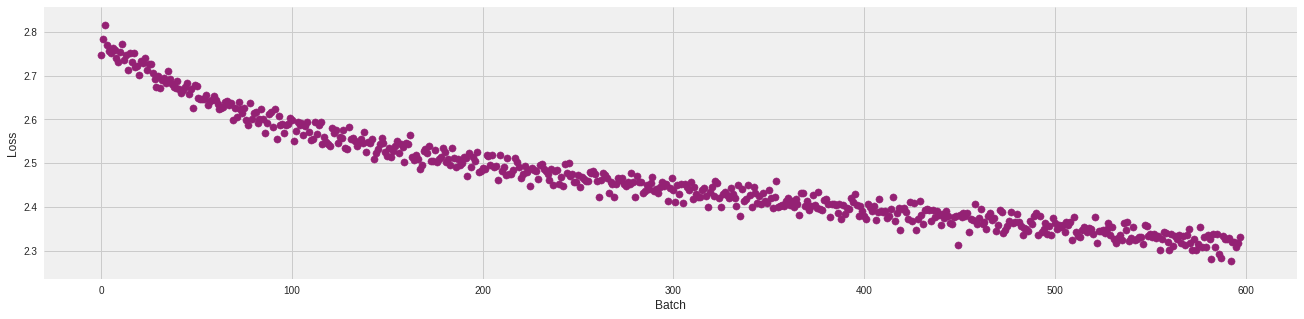

In [70]:
average_step = 100

_, ax = plt.subplots(1, 1, figsize=(20,5))

loss_history = np.array(trainer.loss_history).reshape(-1, average_step).mean(axis=-1)

ax.scatter(np.arange(len(loss_history)), loss_history, color='#942174', s=1+average_step//2);

ax.set_xlabel("Batch")
ax.set_ylabel("Loss");

sns.despine(left=True,bottom=True)
